# Assigning labels for U=37.5 and Mu=37.5 4site dataset

['headers', 'data']
    tx     U   mu  rho0  rho1  rho2  rho3  phi0_sq  phi1_sq  phi2_sq  phi3_sq  \
0  1.0  15.0 -5.0   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
1  1.0  15.0 -4.8   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
2  1.0  15.0 -4.6   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
3  1.0  15.0 -4.4   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   
4  1.0  15.0 -4.2   0.0   0.0   0.0   0.0      0.0      0.0      0.0      0.0   

    E0  iters  
0  0.0     30  
1  0.0     35  
2  0.0     43  
3  0.0     59  
4  0.0    103  
      U   mu  Phase
0  15.0 -5.0      0
1  15.0 -4.8      0
2  15.0 -4.6      0
3  15.0 -4.4      0
4  15.0 -4.2      0


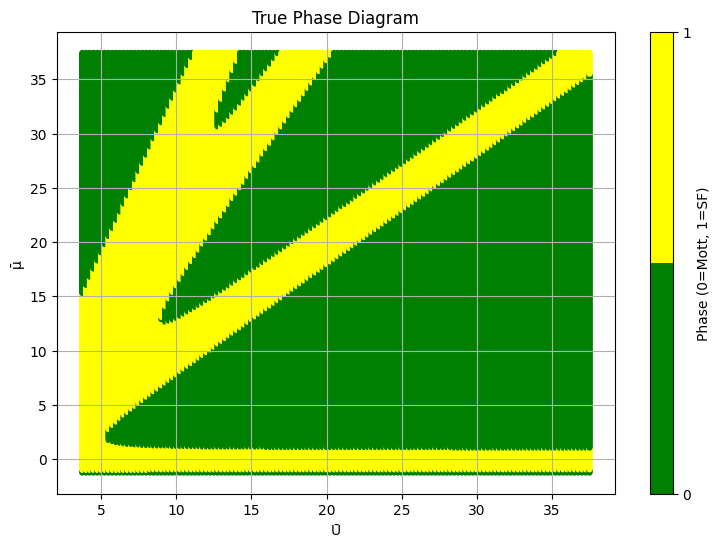

In [2]:
import numpy as np
import pandas as pd

# Load npz file
data = np.load("4site_phase_tx1.0_U(15.0-150.0)-(1.0)_Mu(-5.0-150.0)-(0.2).npz")
# This will show what arrays are inside
print(data.files)

# Load csv file
df = pd.read_csv("4site_phase_tx1.0_U(3.8-37.5)-(1.0)_Mu(-1.2-37.5)-(0.2).csv")
print(df.head())

# Define threshold
threshold = 1e-6  

# Add phase column: 0 = Mott, 1 = Superfluid
df["Phase"] = (df[["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]].sum(axis=1) > threshold).astype(int)

print(df[["U","mu","Phase"]].head())


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Normalize before plotting
z, t = 4, 1.0
df["Ubar"]  = df["U"] / (z*t)
df["Mubar"] = df["mu"] / (z*t)

# plt.figure(figsize=(6,5))
# sc = plt.scatter(df["U"], df["mu"], c=df["Phase"], cmap="bwr", s=15)
# plt.colorbar(sc, label="Phase (0=Mott, 1=Superfluid)")
# plt.xlabel("U")
# plt.ylabel("μ")
# plt.title("Ground Truth Phase Diagram")
# plt.show()

# 2) Plot True Phase Diagram
plt.figure(figsize=(9,6))
plt.scatter(df["Ubar"], df["Mubar"], c=df["Phase"], s=10, cmap=ListedColormap(['green','yellow']))
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
# plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("True Phase Diagram")
plt.grid(True)
plt.show()



In [1]:
import pandas as pd

df = pd.read_csv("4site_phase_tx1.0_U(3.8-37.5)-(1.0)_Mu(-1.2-37.5)-(0.2).csv")

# 1) Normalize coordinates
df["Ubar"]  = df["U"]  
df["Mubar"] = df["mu"]

# 2) Site-invariant phase label
phi_cols = ["phi0_sq","phi1_sq","phi2_sq","phi3_sq"]
df["phi2_avg"] = df[phi_cols].mean(axis=1)
threshold = 1e-6
df["Phase"] = (df["phi2_avg"] > threshold).astype(int)

# 3) Train exactly like 1-site
X = df[["Ubar","Mubar"]].copy()
y = df["Phase"].copy()

# # your existing MLP pipeline 'mlp' works unchanged:
# mlp.fit(X, y)


In [4]:
## Storage for all classification reports

all_reports =[]
def store_report(report_dict, model_name, phase, storage_list,
                 U_min=None, U_max=None, mu_min=None, mu_max=None, U_step=None, mu_step=None):
    """
    Store classification report with model, phase, and grid parameters.
    """
    for cls, metrics in report_dict.items():
        if isinstance(metrics, dict): # per-class or averages
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": metrics.get("precision"),
                "recall": metrics.get("recall"),
                "f1-score": metrics.get("f1-score"),
                "support": metrics.get("support"),
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })
        else:                # e.g. "accuracy": float
            storage_list.append({
                "Model": model_name,
                "Phase": phase,
                "Class": str(cls),
                "precision": None,
                "recall": None,
                "f1-score": metrics,
                "support": None,
                "U_min": U_min, "U_max": U_max,
                "mu_min": mu_min, "mu_max": mu_max,
                "U_step": U_step, "mu_step": mu_step
            })


# MLP on u=150 and mu=150 for 4 site dataset

In [5]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [6]:
def run_models(
    models,X ,y ,
    U_min=0.0, U_max=15.0, 
    mu_min=0.0, mu_max=50.0, 
    U_step=0.1, mu_step=0.1
):
    """
    Run training, evaluation, decision boundary plotting, and prediction reports.
    Default grid limits: U∈[0,15], μ∈[0,50], step=0.1.
    Override using keyword args, e.g. run_models(models, U_max=25, mu_max=60).
    """


    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25, random_state=42,
        stratify=y
    )

    ##plot 1##
    #Plot True phase diagram
    plt.figure(figsize=(9,6))
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue','red']))
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū"); plt.ylabel("μ̄")
    plt.title("True Phase Diagram")
    plt.grid(True)
    plt.show()
 
    '''
    ---------- 3) Train + Evaluate ----------
    '''

    # ---------- 4) Plot decision boundary on training domain ----------
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()

        # Clip negatives if needed
        x_min = max(0, x_min)
        y_min = max(0, y_min)


        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)

            # Filter training points so negative μ̄ don’t affect the axis
        mask = X["Mubar"] >= 0
        plt.scatter(
            X.loc[mask, "Ubar"], 
            X.loc[mask, "Mubar"], 
            c=y.loc[mask],
            s=10, cmap=ListedColormap(['blue', 'red']),
            edgecolor='k', linewidth=0.2
        )
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()

        
    # def train_test(models,X_tain,y_train):
    for name, model in models.items():
            model.fit(X_train, y_train)

            # Plot Training Results 
            
            # plot_decision_boundary(model, X, y, title="T", grid_res=300):
            
            y_pred = model.predict(X_test)
            print(f"\n📊 Classification Report for {name}:")
            report_test = classification_report(y_test, y_pred, digits=4, output_dict=True)
            store_report(report_test, name, "test", all_reports,
                         U_min, U_max, mu_min, mu_max, U_step, mu_step)
            print(classification_report(y_test, y_pred, digits=4))
    
        
    
    
    for name,model  in models.items():
        # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
        clf = model  # or "LogReg-Poly2" or "RF-Shallow"
        
        plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
        
        # # ---------- 5) Predict on an extended grid (extrapolation) ----------
        # U_min, U_max = 0.0, 15.0   # extend beyond training range
        # mu_min, mu_max = 0.0, 50.0
        # U_step, mu_step = 0.1, 0.1
    
        
        U_vals = np.arange(U_min, U_max + U_step, U_step)
        mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
        U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
        
        grid_ext = pd.DataFrame({
            "Ubar": U_grid.ravel(),
            "Mubar": mu_grid.ravel()
        })
        
        pred_ext = clf.predict(grid_ext)
    
        phase_map = pred_ext.reshape(U_grid.shape)
        
        plt.figure(figsize=(9, 6))

        # if we want to see the predict of unknown datapoints and tarining prediction on the known datapoints comparisions
        # # Background prediction (gray/orange)
        # plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        
        # # Overlay true training data (blue/red)
        # plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        

        plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
        plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
        plt.clim(-0.5, 1.5)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title("Predicted Phase Diagram for Model ")
        plt.grid(True)
        plt.show()
        
        # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
        # Only compare inside the original data domain (U≤15, μ≤50)
        mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
        grid_in_domain = grid_ext[mask_domain].copy()
        pred_in_domain = clf.predict(grid_in_domain)
          
       
        df_lookup = df.copy()
        df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
        df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
        lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
        lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
        
        grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
        grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
        true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
        
        # Drop NaNs (grid points that don't map exactly to a dataset point)
        valid = ~pd.isna(true_labels)
        true_labels = true_labels[valid].astype(int)
        pred_labels = pred_in_domain[valid]
        
        print(f"\n📊 Classification Report For Prediction using Model {name} :")
        report_pred = classification_report(true_labels, pred_labels, digits=4, output_dict=True)
        store_report(report_pred, name, "prediction", all_reports,
                     U_min, U_max, mu_min, mu_max, U_step, mu_step)
        print(classification_report(true_labels, pred_labels, digits=4))


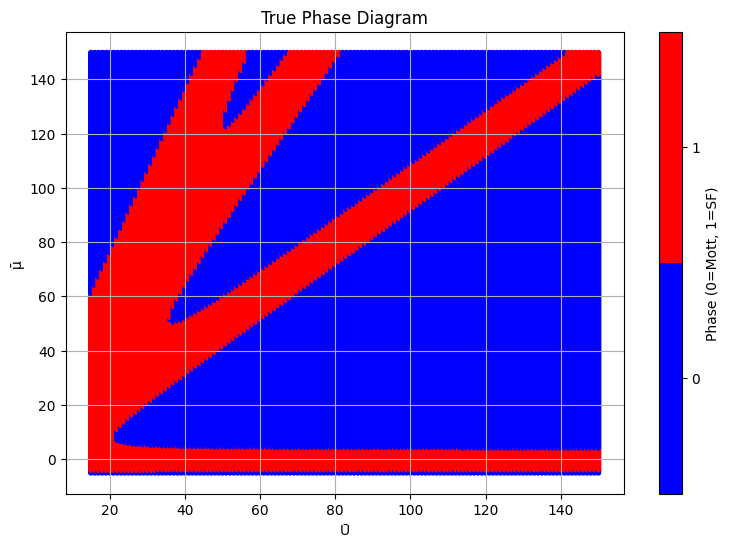


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9983    0.9935    0.9959     18086
           1     0.9859    0.9962    0.9910      8264

    accuracy                         0.9943     26350
   macro avg     0.9921    0.9949    0.9935     26350
weighted avg     0.9944    0.9943    0.9944     26350



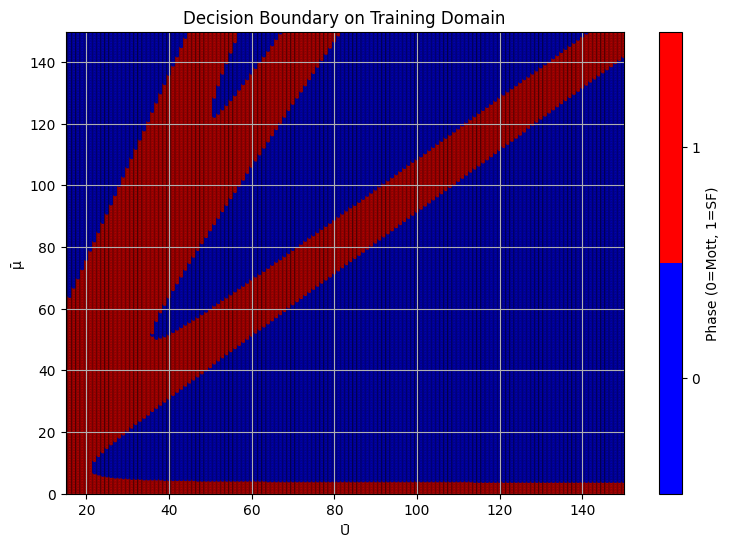

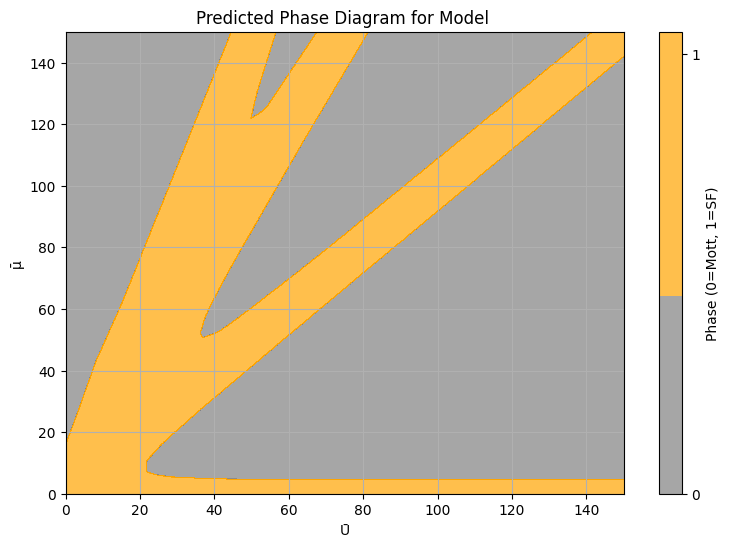


📊 Classification Report For Prediction using Model MLP :
              precision    recall  f1-score   support

           0     0.9984    0.9956    0.9970     71546
           1     0.9897    0.9963    0.9930     30454

    accuracy                         0.9958    102000
   macro avg     0.9941    0.9960    0.9950    102000
weighted avg     0.9958    0.9958    0.9958    102000



In [8]:
# Model 
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

models = {
    "MLP": mlp
}

run_models(models,X,y, U_max= 150, mu_max=150) 